
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi




In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [3]:
!pip install -q gymnasium pybullet-envs-gymnasium Box2D moviepy
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 62.0 MB/s eta 0:00:00
Fri Sep  5 02:02:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W

In [4]:
!pip install -q gymnasium[mujoco]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 21.7 MB/s eta 0:00:00


In [5]:
!pip install -q pyvirtualdisplay
!sudo apt-get install -y xvfb python3-opengl ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


Import necessary packages.

In [6]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import pybullet_envs
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [7]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [8]:
class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False
        self.current_size = 0


        # TODO: Initialize buffer arrays to store states, next states, actions, rewards, and done flags
        self.states = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.next_states = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.actions = np.zeros((buffer_size, action_dims), dtype=np.float32)
        self.rewards = np.zeros(buffer_size, dtype=np.float32)
        self.doneFlags = np.zeros(buffer_size, np.bool_)

    def store_transition(self, state, action, reward, state_, done):
        # TODO : Store the transition in the replay buffer
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.next_states[self.ptr] = state_
        self.rewards[self.ptr] = reward
        self.doneFlags[self.ptr] = done


        self.ptr = (self.ptr + 1) % self.buffer_size
        self.current_size = min(self.current_size + 1, self.buffer_size)

    def load_batch(self, batch_size):
        # TODO: Sample a random batch of transitions from the buffer
        batch_indices = np.random.choice(self.current_size, batch_size, replace=False)

        states = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.next_states[batch_indices]
        done = self.doneFlags[batch_indices]

        return states, actions, rewards, states_, done

## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [9]:
class Critic(nn.Module):
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()

        # TODO 1: Save input arguments as attributes
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name)
        os.makedirs(self.ckpt_dir, exist_ok=True)


        # TODO 2: Define the first fully connected layer
        # The input is the concatenation of state and action
        self.fc1 = nn.Linear(state_dims + action_dims, fc1_dims)


        # TODO 3: Define the second hidden layer and the final Q-value output layer
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.q_out = nn.Linear(fc2_dims, 1)

        # TODO 4: Define the optimizer. Assign to the correct device
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        self.optimizer = optim.Adam(self.parameters(), lr=self.beta)

    def forward(self, state, action):
        state_action = T.cat([state, action], dim=-1)
        # Used self.q_head here
        q = self.q_out(F.relu(self.fc2(F.relu(self.fc1(state_action)))))
        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Actor(nn.Module):
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):
        super(Actor, self).__init__()
        # TODO 1: Store initialization parameters
        self.alpha = alpha
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.max_action = max_action
        self.reparam_noise = reparam_noise
        self.name = name
        self.ckpt_dir =ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name)
        os.makedirs(self.ckpt_dir, exist_ok=True)


        # TODO 2: Define fully connected layers to transform input state
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU()
        )

        # TODO 3: Output mean and standard deviation for the Gaussian policy
        self.mean_head = nn.Linear(fc2_dims, action_dims)
        self.log_std_head = nn.Linear(fc2_dims, action_dims)

        # TODO 4: Define optimizer and move model to the appropriate device
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha)
        self.log_std_min = -20
        self.log_std_max = 2


    def forward(self, state):
        #TODO
        features = self.shared_layers(state)
        mu = self.mean_head(features)
        log_std = self.log_std_head(features)
        log_std = T.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu, log_std

    def sample_normal(self, state, reparameterize=True):
        # TODO 7: Use the actor to compute distribution parameters
        mean, log_std = self.forward(state)
        std = log_std.exp()

        normal = Normal(mean, std)
        raw_action = normal.rsample() if reparameterize else normal.sample()

        actions_tanh = T.tanh(raw_action)
        actions_scaled = actions_tanh * self.max_action

        log_probs = normal.log_prob(raw_action)
        log_probs -= T.log(1 - actions_tanh.pow(2) + self.reparam_noise)
        log_probs = log_probs.sum(1, keepdim=True)

        return actions_scaled, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Value(nn.Module):
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims, name='Value', ckpt_dir='tmp'):
        super(Value, self).__init__()

        # TODO 1: Save arguments as instance variables
        self.beta = beta
        self.state_dims = state_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name)
        os.makedirs(self.ckpt_dir, exist_ok=True)


        # TODO 2: Define the fully connected layers for value approximation
        self.fc1 = nn.Linear(state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.v = nn.Linear(fc2_dims, 1) # Outputs a single V-value


        # TODO 3: Set optimizer and device
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        self.optimizer = optim.Adam(self.parameters(), lr=self.beta)


    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))

## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [10]:
class Agent:
    def __init__(self, gamma, alpha, beta, state_dims, action_dims, max_action, fc1_dim, fc2_dim,
                 memory_size, batch_size, tau, update_period, reward_scale, warmup, reparam_noise_lim,
                 name, entr=None, ckpt_dir='tmp'):
        # TODO 1: Save all hyperparameters and paths
        self.gamma = gamma
        self.tau = tau
        self.update_period = update_period
        self.reward_scale = reward_scale
        self.warmup = warmup
        self.batch_size = batch_size
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.total_env_steps = 0
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.max_action = max_action

        self.replay_buffer = ReplayBuffer(memory_size, state_dims, action_dims)
        self.actor = Actor(alpha, state_dims, action_dims, fc1_dim, fc2_dim, max_action, reparam_noise_lim)
        self.critic_1 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, 'Critic_1')
        self.critic_2 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, 'Critic_2')

        self.target_critic_1 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, 'Target_Critic_1')
        self.target_critic_2 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, 'Target_Critic_2')

        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())

        for p in self.target_critic_1.parameters(): p.requires_grad = False
        for p in self.target_critic_2.parameters(): p.requires_grad = False


        self.target_entropy = -T.tensor(action_dims, dtype=T.float32).to(self.device)
        self.log_alpha = T.tensor(0.0, dtype=T.float32, device=self.device, requires_grad=True)
        self.alpha_optimizer = T.optim.Adam([self.log_alpha], lr=beta)

        self.learn_iter = 0


    def choose_action(self, state, deterministic=False, reparameterize=False):

        # TODO 6: Convert state to tensor, move to device, and add batch dimension
        state_tensor = T.tensor(state, dtype=T.float32, device=self.device).unsqueeze(0)

        with T.no_grad():
            if deterministic:
                mu, _ = self.actor.forward(state_tensor)
                action = T.tanh(mu) * self.max_action
            else:
                action, _ = self.actor.sample_normal(state_tensor, reparameterize=False)

        return action.squeeze(0).cpu().numpy()


    def store_transition(self, state, action, reward, state_, done):
        self.replay_buffer.store_transition(state, action, reward, state_, done)
        self.total_env_steps += 1

    def load_batch(self):
        states, actions, rewards, next_states, done = self.replay_buffer.load_batch(self.batch_size)
        states = T.tensor(states, dtype=T.float32, device=self.device)
        actions = T.tensor(actions, dtype=T.float32, device=self.device)
        rewards = T.tensor(rewards, dtype=T.float32, device=self.device).unsqueeze(-1)
        next_states = T.tensor(next_states, dtype=T.float32, device=self.device)
        done = T.tensor(done, dtype=T.float32, device=self.device).unsqueeze(-1)
        return states, actions, rewards, next_states, done

    @T.no_grad()
    def _soft_update(self, network, target_network, tau=None):
        tau = self.tau if tau is None else tau
        for param, target_param in zip(network.parameters(), target_network.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def update_parameters(self):
        self._soft_update(self.critic_1, self.target_critic_1)
        self._soft_update(self.critic_2, self.target_critic_2)




    def save_model(self):
        print('... saving checkpoint ...')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.target_critic_1.save_checkpoint()
        self.target_critic_2.save_checkpoint()
        alpha_checkpoint = {
            'log_alpha': self.log_alpha,
            'alpha_optimizer': self.alpha_optimizer.state_dict()
        }
        T.save(alpha_checkpoint, os.path.join(self.ckpt_dir, f'{self.name}_alpha.pth'))

    def load_model(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        alpha_path = os.path.join(self.ckpt_dir, f'{self.name}_alpha.pth')
        if os.path.exists(alpha_path):
            checkpoint = T.load(alpha_path, map_location=self.device)
            self.log_alpha = checkpoint['log_alpha']
            self.alpha_optimizer.load_state_dict(checkpoint['alpha_optimizer'])

    def learn(self):

        # TODO 11: Skip learning during warm-up period or insufficient samples
        if self.replay_buffer.current_size < self.batch_size:
            return

        if self.learn_iter % self.update_period != 0:
            self.learn_iter += 1
            return

        # === VALUE LOSS ===
        states, actions, rewards, next_states, terminals = self.load_batch()
        rewards = self.reward_scale * rewards

        alpha = self.log_alpha.exp()

        with T.no_grad():
            next_actions, next_log_probs = self.actor.sample_normal(next_states, reparameterize=False)
            target_q1 = self.target_critic_1(next_states, next_actions)
            target_q2 = self.target_critic_2(next_states, next_actions)
            target_q_min = T.min(target_q1, target_q2) - alpha * next_log_probs
            q_target = rewards + self.gamma * (1 - terminals) * target_q_min


        # TODO 13: Estimate Q-values
        q1 = self.critic_1(states, actions)
        q2 = self.critic_2(states, actions)
        critic1_loss = F.mse_loss(q1, q_target)
        critic2_loss = F.mse_loss(q2, q_target)

        self.critic_1.optimizer.zero_grad()
        critic1_loss.backward()
        self.critic_1.optimizer.step()

        self.critic_2.optimizer.zero_grad()
        critic2_loss.backward()
        self.critic_2.optimizer.step()


        # TODO 14: Compute target value
        # value_target = (q_pred - log_probs).detach()


        # TODO 15: Compute value loss and update value network
        # value_loss = F.mse_loss(value_pred, value_target)
        # self.value.optimizer.zero_grad()
        # value_loss.backward(retain_graph=True) # Retain graph for actor/critic updates
        # self.value.optimizer.step()


        # === ACTOR LOSS ===
        # TODO 16: Re-sample actions (this time with reparameterization for gradients)
        new_actions, log_probs = self.actor.sample_normal(states, reparameterize=True)
        q1_new = self.critic_1(states, new_actions)
        q2_new = self.critic_2(states, new_actions)
        q_new_min = T.min(q1_new, q2_new)

        actor_loss = (alpha * log_probs - q_new_min).mean()
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()



        # TODO 17: maximize entropy-regularized Q-value
        alpha_loss = -(self.log_alpha * (log_probs.detach() + self.target_entropy)).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        self.update_parameters()
        self.learn_iter += 1

## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [11]:
# Configuration parameters


env_name = 'HalfCheetah-v4'
dir = 'tmp'
n_games = 300


gamma = 0.99
alpha = 3e-4
beta = 3e-4
fc1_dim = 256
fc2_dim = 256
# Add other network dims if needed
memory_size = 1000000
batch_size = 256
tau = 0.005
update_period = 1
reward_scale = 5.
warmup = 10000
reparam_noise_lim = 1e-6
record_video = True

## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

In [12]:
from pyvirtualdisplay import Display

# Start the virtual display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  0%|          | 0/300 [00:00<?, ?it/s]

... saving checkpoint ...
| Game:      0 | Score:    -366.26 | Best score:    -366.26 | Avg score    -366.26 | Learning iter:        745 |
Evaluation Score in 'Deterministic' mode: -80.25
... saving checkpoint ...
| Game:      1 | Score:    -214.61 | Best score:    -290.44 | Avg score    -290.44 | Learning iter:       1745 |
... saving checkpoint ...
| Game:      2 | Score:    -275.75 | Best score:    -285.54 | Avg score    -285.54 | Learning iter:       2745 |
| Game:      3 | Score:    -355.06 | Best score:    -285.54 | Avg score    -302.92 | Learning iter:       3745 |
... saving checkpoint ...
| Game:      4 | Score:    -189.64 | Best score:    -280.26 | Avg score    -280.26 | Learning iter:       4745 |
... saving checkpoint ...
| Game:      5 | Score:    -244.63 | Best score:    -274.33 | Avg score    -274.33 | Learning iter:       5745 |
| Game:      6 | Score:    -313.16 | Best score:    -274.33 | Avg score    -279.87 | Learning iter:       6745 |
... saving checkpoint ...
| Ga

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


... saving checkpoint ...
| Game:    295 | Score:    5899.13 | Best score:    5647.51 | Avg score    5647.51 | Learning iter:     295745 |
... saving checkpoint ...
| Game:    296 | Score:    5626.35 | Best score:    5651.45 | Avg score    5651.45 | Learning iter:     296745 |
... saving checkpoint ...
| Game:    297 | Score:    5998.31 | Best score:    5656.62 | Avg score    5656.62 | Learning iter:     297745 |
... saving checkpoint ...
| Game:    298 | Score:    5945.25 | Best score:    5662.23 | Avg score    5662.23 | Learning iter:     298745 |
... saving checkpoint ...
| Game:    299 | Score:    6100.76 | Best score:    5669.28 | Avg score    5669.28 | Learning iter:     299745 |


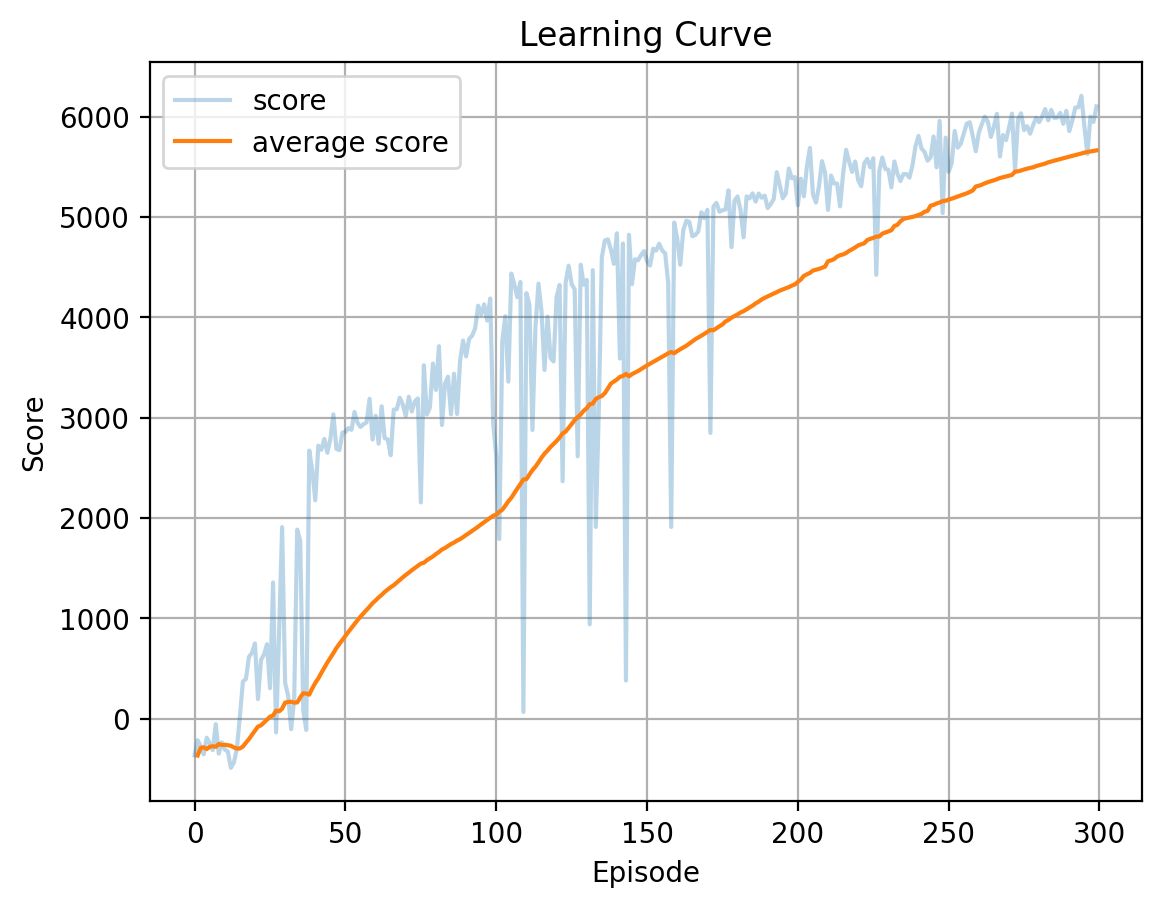

In [13]:
# env = gym.make(env_name, render_mode="rgb_array")
# dir_path = os.path.join(dir, env_name)
env = gym.make(env_name, render_mode='rgb_array')
dir_path = os.path.join(dir, env_name)

os.makedirs(dir_path, exist_ok=True)

if record_video:
    env = RecordVideo(env, video_folder=os.path.join(dir_path, 'videos'),
                      episode_trigger=lambda ep: ep == n_games - 1)


state_dims = env.observation_space.shape[0]
action_dims = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

agent = Agent(
    gamma=gamma, alpha=alpha, beta=beta,
    state_dims=state_dims, action_dims=action_dims, max_action=max_action,
    fc1_dim=fc1_dim, fc2_dim=fc2_dim,
    memory_size=memory_size, batch_size=batch_size, tau=tau,
    update_period=update_period, reward_scale=reward_scale,
    warmup=warmup, reparam_noise_lim=reparam_noise_lim,
    name='SAC', ckpt_dir=dir_path
)


# TODO: Initialize performance tracking variables
scores = []
best_score = -np.inf

for game in trange(n_games):
    # TODO: Reset environment and initialize variables at the start of each episode
    observation, _ = env.reset()
    done = False
    score = 0.0

    # TODO: Interact with the environment until the episode is done
    while not done:
        if agent.total_env_steps < agent.warmup:
            action = env.action_space.sample()
        else:
            action = agent.choose_action(observation, deterministic=False)

        observation_, reward, terminated, truncated, info = env.step(action)
        done = bool(terminated or truncated)

        agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()

        observation = observation_
        score += reward


    # TODO: Track score and average score for plotting and saving
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    if avg_score > best_score:
        best_score = avg_score
        agent.save_model()

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')


    # TODO: Save the model if the current avg score is better than the best so far
    if game % 50 == 0:
        eval_score = 0
        eval_obs, _ = env.reset()
        eval_done = False
        while not eval_done:
            action = agent.choose_action(eval_obs, deterministic=True)
            next_obs, reward, terminated, truncated, info = env.step(action)
            eval_done = bool(terminated or truncated)
            eval_score += reward
            eval_obs = next_obs
        print(f"Evaluation Score in 'Deterministic' mode: {eval_score:.2f}")


env.close()

plot_learning_curve(scores, agent.actor.ckpt_dir)

## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [14]:
Video(f"/content/tmp/HalfCheetah-v4/videos/rl-video-episode-{n_games - 1}.mp4", embed=True, width=600)